# LeNet CIFAR10 Classifier

#### The CIFAR10 dataset has 60,000 samples

The samples are 32x32x3 RGB images with intensity ranges [0,255] (uint8). 

The dataset is divided into 10 classes:

0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck


### Import the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
    
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

### Load train and test sets using Pytorch datasets functions
Make sure the intensity range is between $[0, 1]$ and images are stored as 'tensor' type

In [2]:
# First import just the trainset for inspection
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, # 50,000 images
                                       download=True)

|          | 0/? [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
# Are the image intensity ranges normalized?

# Sample the first picture of the CIFAR10 trainset as a representation of the whole set.
np_im = np.array(trainset[0][0]) 
min_val = np.amin(np_im)
max_val = np.amax(np_im)

print('The data type of the trainset image values is {}.'.format(type(min_val)))
print('The intensity range is [{},{}].'.format(min_val, max_val))
if max_val != 1.0:
    print("We should normalize the dataset!")
else:
    print("The trainset seems to be normalized!")

The data type of the trainset image values is <class 'numpy.uint8'>.
The intensity range is [0,255].
We should normalize the dataset!


In [4]:
# Load both the train and test sets and normalize the intensity ranges using
# ToTensor() and Normalize().

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, # 50,000 images
                                       download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, # 10,000 images
                                       download=True, transform=transform)

np_im = np.array(trainset[0][0]) 
min_val = np.amin(np_im)
max_val = np.amax(np_im)

print('\nThe data type of the trainset image values is {}.'.format(type(min_val)))
print('The intensity range is [{},{}].'.format(min_val, max_val))
if min_val != -1.0 and max_val != 1.0:
    print("We should normalize it! \n")
else:
    print("The trainset is normalized! \n")
    
print('The data type of the testset image values is {}.'.format(type(min_val)))
print('The intensity range is [{},{}].'.format(min_val, max_val))
if min_val != -1 and max_val != 1.0:
    print("We should normalize it!")
else:
    print("The testset is normalized!")

Files already downloaded and verified
Files already downloaded and verified

The data type of the trainset image values is <class 'numpy.float32'>.
The intensity range is [-1.0,1.0].
The trainset is normalized! 

The data type of the testset image values is <class 'numpy.float32'>.
The intensity range is [-1.0,1.0].
The testset is normalized!


### Display images and histograms
Use the 'matplotlib' library to display one random sample of each class from both the trainset and the testset

In [5]:
# Pull samples from each class in trainset and testset, with labels
# and convert to numpy for better handling downstream.

N = 10 # mumber of classes

train_ims = [[None, None]] * N
for (x,y) in trainset:
     if train_ims[y][0] is None:
        train_ims[y] = (x.numpy(),y)  # image tensors to arrays, label as int

# repeat for testset
test_ims = [[None, None]] * N
for (x,y) in testset:
     if test_ims[y][0] is None:
        test_ims[y] = (x.numpy(),y)

In [6]:
# Create a function that returns a histogram of intensities for each color channel.
def GetHistograms(img):
    histograms = []
    for i in range(3):
        hist, edge = np.histogram(img[i], bins=100, range=[0.0,1.0])
        edge = (edge[:-1] + edge[1:])/2
        histograms.append((edge,hist))
        
    return histograms

colors = ('Red','Green','Blue') # color channel label strings for plotting

In [7]:
def ImsAndHists(trainset,testset):

    fig,ax = plt.subplots(nrows = N, ncols = 4, figsize=(20,20))

    for index, im in enumerate(trainset):

        img = im[0]  
        img = img / 2 + 0.5 # unnormalize

        ax[index][0].imshow(np.transpose(img, (1, 2, 0)))
        ax[index][0].title.set_text(classes[im[1]]+' (trainset)')
        ax[index][0].axis('off')

        histograms = GetHistograms(img)
        for i in range(3):
            ax[index][1].plot(histograms[i][0], histograms[i][1], c=colors[i], label='Channel {0}'.format(colors[i]))

        ax[index][1].title.set_text(classes[im[1]]+' histogram (trainset)')
        ax[index][1].set_xlabel('Intensity')
        ax[index][1].set_ylabel('Abundance')
        ax[index][1].legend()
        plt.tight_layout()


    for index, im in enumerate(testset):

        img = im[0]  
        img = img / 2 + 0.5 # unnormalize

        ax[index][2].imshow(np.transpose(img, (1, 2, 0)))
        ax[index][2].title.set_text(classes[im[1]]+' (testset)')
        ax[index][2].axis('off')

        histograms = GetHistograms(img)
        for i in range(3):
            ax[index][3].plot(histograms[i][0], histograms[i][1], c=colors[i], label='Channel {0}'.format(colors[i]))

        ax[index][3].title.set_text(classes[im[1]]+' histogram (testset)')
        ax[index][3].set_xlabel('Intensity')
        ax[index][3].set_ylabel('Abundance')
        ax[index][3].legend()
        plt.tight_layout()

    plt.show()

classes = ('airplane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # image label strings for plot titles

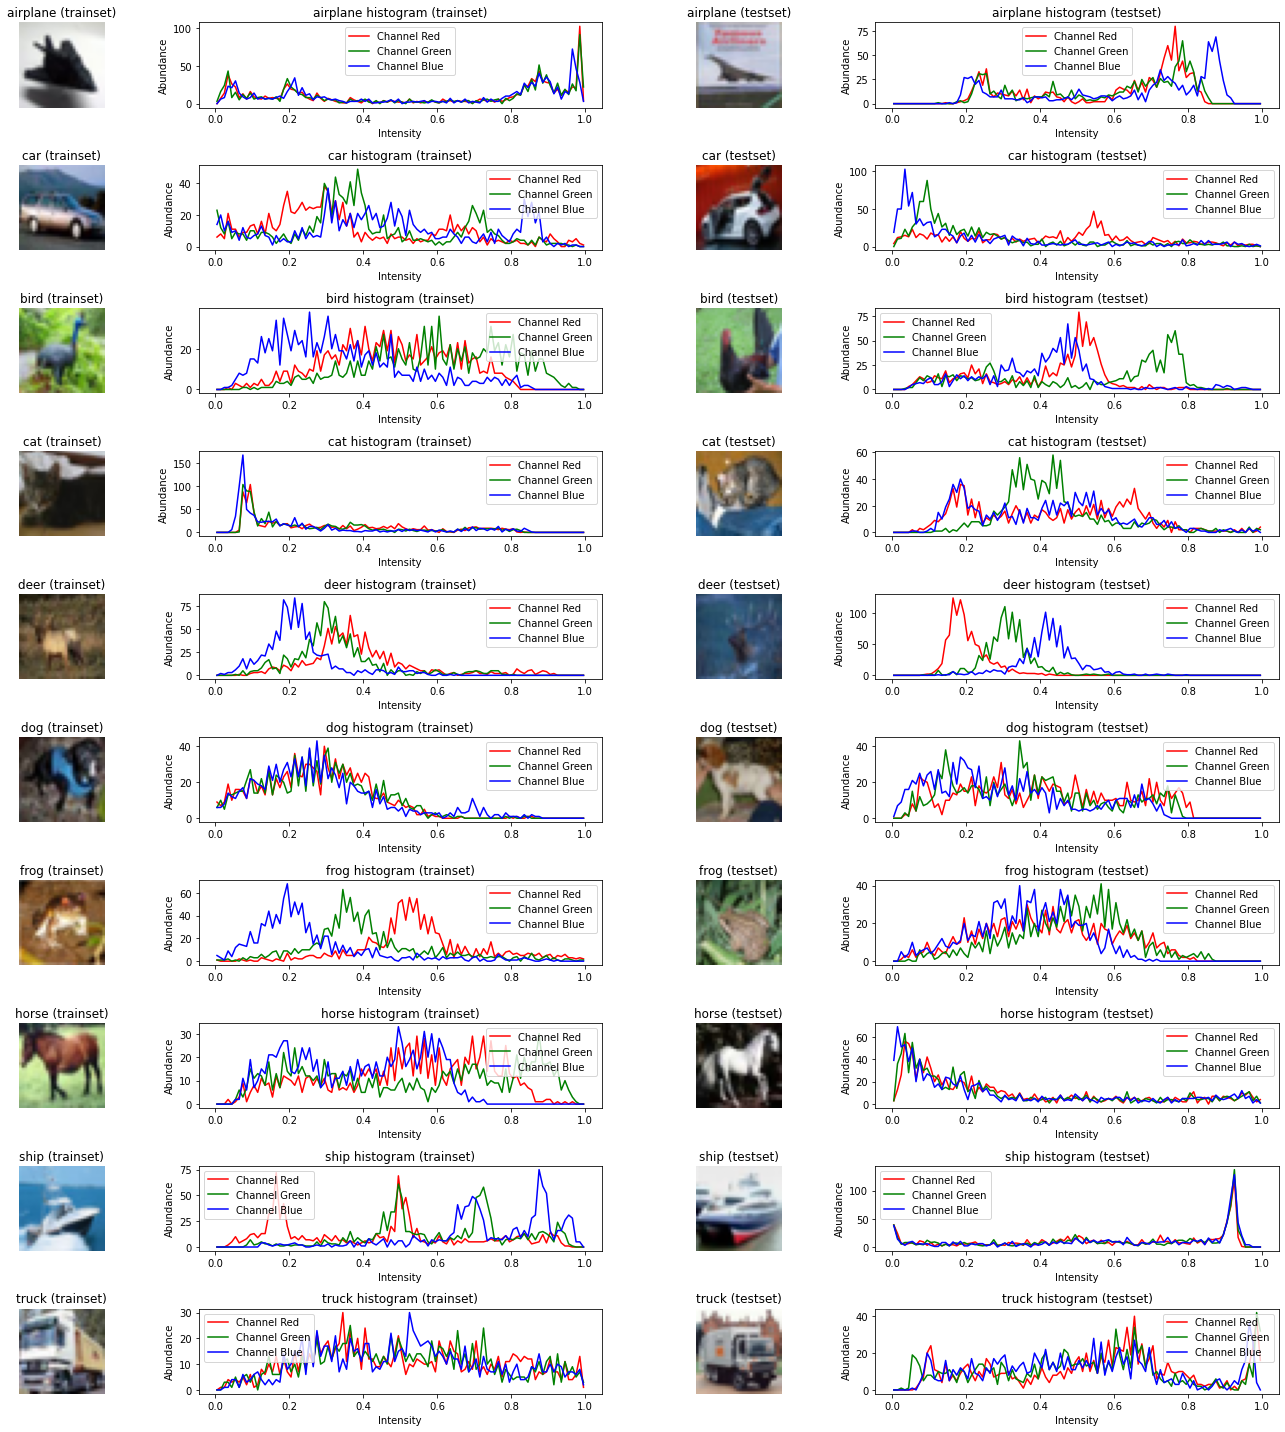

In [8]:
ImsAndHists(train_ims,test_ims)

### Split up the train set into new train and validation sets


In [9]:
# Shuffle the trainset indices
train_rand_index = np.random.permutation(range(len(trainset)))

split = len(testset)

train_indices, val_indices = train_rand_index[split:], train_rand_index[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create dataloaders
trainloader = DataLoader(dataset=trainset, 
                         shuffle=False, batch_size=32, 
                         sampler=train_sampler)

valloader = DataLoader(dataset=trainset, 
                        shuffle=False, batch_size=32, 
                        sampler=val_sampler)

testloader = DataLoader(dataset=testset, 
                         shuffle=False, batch_size=32)

test_y = testset.targets # already as int type

### Display the number of samples for each class in the train, validation, and test sets as a stacked bar plot

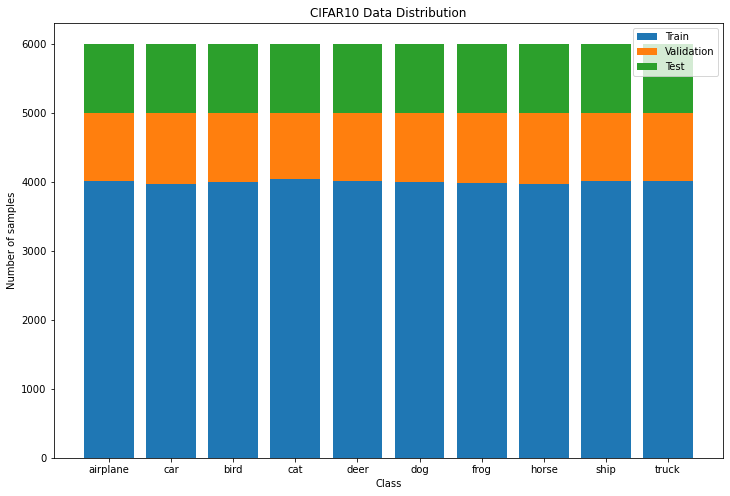

In [10]:
train_counts = np.zeros(10)
val_counts = np.zeros(10)
test_counts = np.zeros(10)

for i in train_indices:
    train_counts[trainset[i][1]] += 1

for i in val_indices:
    val_counts[trainset[i][1]] += 1

for i in range(len(testset)):
    test_counts[testset[i][1]] += 1
    
plt.figure(figsize=(12,8))
plt.bar(range(N), train_counts, tick_label=classes, label='Train')
plt.bar(range(N), val_counts, bottom=train_counts, label='Validation')
plt.bar(range(N), test_counts, bottom=train_counts+val_counts, label='Test')
plt.title('CIFAR10 Data Distribution')
plt.ylabel('Number of samples')
plt.xticks(range(N), labels=classes)
plt.xlabel('Class')
plt.legend()
plt.show()

### Construct the LeNet model
**Architecture hyper-parameters:**
* Number of layers: 4 (two convolutional layers, two fully connected layers)
* Number of kernels in conv layer 1: 6
* Number of kernels in conv layer 2: 16
* There are no kernels in the 2 fully connected layers.

* Size of kernel in conv layer 1: 5x5
* Size of kernel in conv layer 2: 5x5

* Stride = 1

* Zero-padding = 0
![LeNet Architecture](https://raw.githubusercontent.com/soroush361/DeepLearningInBME/main/Ass1_Arch1.png)

In [11]:
# Implement the LeNet architecture
## The dimensions of our inputs are 32x32x3
## By the kernel formula, the dimensions of conv1 imply that 
## we will need a 5x5 kernel

class Net(nn.Module):
    def __init__(self):
        # 3 input image channels, 6 output channels, 5x5 square conv kernel
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2,2) window
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Assuming GPU is available, move the model to GPU.
net.cuda()

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Create an instance of ADAM optimizer with an initial learning rate of $0.0001$ and an instance of Mean Squared Error (MSE) loss function
**ADAM Optimizer**
* ADAM stands for Adaptive Moment Estimation and combines a momentum-based gradient descent algorithm with the RMSprop algorithm. B1 computes the mean of the derivatives (first moment) while B2 computes the exponential weight average of the squares (second moment). The two combine to create a more balanced optimizing algorithm that generalizes more than either a momentum-based GD algorithm or the RMSprop algorithm alone. The learning rate acts as a scaling factor, requiring the most tuning of all hyperparameters. 0.9 is recommended for the value of B1 and 0.999 is recommended for the value of B2. 10e-8 is recommended for epsilon.


**MSE Loss Function**
* MSE stands for Mean Squared Error Loss. It is calculated as the average of the squared differences between the predicted values of a model and the actual values of a dataset. MSE has the disadvantage of being heavily influenced by outliers, which may require extra data-cleaning. 


In [12]:
# Define our Adam optimizer
optimizer = Adam(net.parameters(), lr=0.0001)

# Create an instance of the MSE Loss Function
criterion = nn.MSELoss()

### Train the model for 50 epochs using the train set and validate the model's performance at the end of each epoch using the validation sets

In [13]:
# Create a folder to save our trained model at the end of each epoch.
!mkdir saved_models

In [14]:
EPOCHS = 50

train_epoch_loss = []
validation_epoch_loss = []

for epoch in range(EPOCHS):
    train_loss = []
    validation_loss = []

    for batch_index, (train_image, train_label) in enumerate(trainloader):
        #######################################################
        ###################### Validation #####################
        #######################################################
    
        # Assume GPU is available
        net.train()

        train_ohe = F.one_hot(train_label, num_classes=N)
        train_ohe = train_ohe.type(torch.FloatTensor)
        train_label_predicted = net(train_image.cuda())

        # compute the loss
        loss = criterion(train_label_predicted, train_ohe.cuda())
        train_loss.append(loss.cpu().data.item())
        
        # reset the gradient 
        optimizer.zero_grad()
        # backpropagate the loss
        loss.backward()
        # update the parameters
        optimizer.step()

        #######################################################
        ###################### Validation #####################
        #######################################################
        # Set the model to evaluation mode so that parameters are fixed.
        net.eval()
        
    for batch_index, (val_image, val_label) in enumerate(valloader):
        
        val_ohe = F.one_hot(val_label, num_classes=N)
        val_ohe = val_ohe.type(torch.FloatTensor)
        validation_label_predicted = net(val_image.cuda())

        loss = criterion(validation_label_predicted, val_ohe.cuda())
        validation_loss.append(loss.cpu().data.item())

    train_epoch_loss.append(np.mean(train_loss))
    validation_epoch_loss.append(np.mean(validation_loss))
    
    # save models
    torch.save(net.state_dict(), './saved_models/checkpoint_epoch_%s.pth' % (epoch))

    print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))

Epoch: 0 | train_loss: 0.0804350007712841 | validation_loss: 0.07589130222606964
Epoch: 1 | train_loss: 0.0732522254139185 | validation_loss: 0.07205360474439855
Epoch: 2 | train_loss: 0.06959748123586178 | validation_loss: 0.06815009611768845
Epoch: 3 | train_loss: 0.06705103331506253 | validation_loss: 0.0662213201149584
Epoch: 4 | train_loss: 0.06500524103343487 | validation_loss: 0.06469866077597149
Epoch: 5 | train_loss: 0.06329784745275974 | validation_loss: 0.0633135720754203
Epoch: 6 | train_loss: 0.06181792313754558 | validation_loss: 0.0620260343503076
Epoch: 7 | train_loss: 0.06046518924832344 | validation_loss: 0.06140460572636927
Epoch: 8 | train_loss: 0.05923196656703949 | validation_loss: 0.06005659091253631
Epoch: 9 | train_loss: 0.0580660484790802 | validation_loss: 0.0592775712021814
Epoch: 10 | train_loss: 0.05704728931188583 | validation_loss: 0.058623143087941615
Epoch: 11 | train_loss: 0.05610188356935978 | validation_loss: 0.05767321026030059
Epoch: 12 | train_lo

### Display the learning curve and identify the best epoch

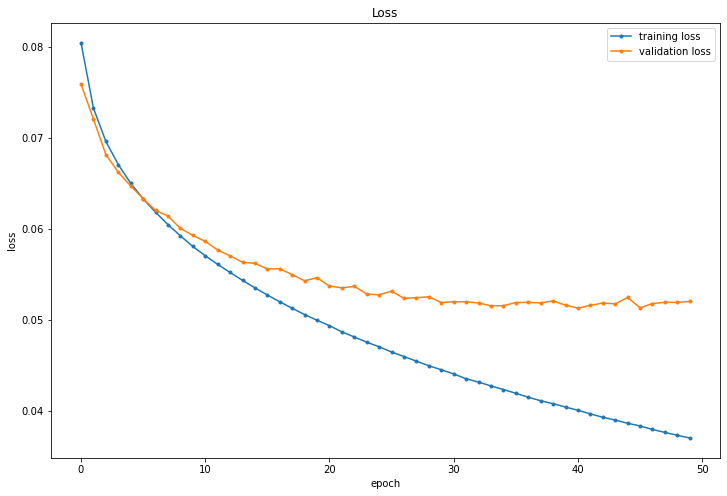

In [15]:
# Draw the learning curve
plt.figure(figsize = (12, 8))
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(train_epoch_loss, '-o', label = 'training loss', markersize = 3)
plt.plot(validation_epoch_loss, '-o', label = 'validation loss', markersize = 3)
plt.legend(loc = 'upper right');

The learning curve shows the model's loss and accuracy at the end of each epoch for all epochs. The criteria for the best epoch may be the minimum loss, maximum accuracy, or other criteria.

In [16]:
# Display the best epoch
best_epoch = np.argmin(validation_epoch_loss)
print('Best epoch: ', best_epoch)

Best epoch:  40


The learning curve shows the model's loss and accuracy at the end of each epoch for all epochs. The criteria for the best epoch may be the minimum loss, maximum accuracy, or other criteria.

Here, we consider minimum validation loss as the criterion for best epoch. Train loss tends to flatten toward zero during later epochs while validation loss sometimes increases due to overfitting. The validation loss thus gives the clearest picture of the model's latest/best performance, and should be used as a starting point for tuning hyperparameters, such as learning rate.

### Load the model's weights at the best epoch and test the model performance on the test set.

In [17]:
# Load the best model
state_dict = torch.load('./saved_models/checkpoint_epoch_%s.pth' % (best_epoch))
print(state_dict.keys())
net.load_state_dict(state_dict)

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


<All keys matched successfully>

In [18]:
# Evaluate the model on the test set

net.eval()
test_label_predicted_all = []

for batch_index, (test_image, test_label) in enumerate(testloader):
        
    test_label_predicted_one_hot = net(test_image.cuda())
    test_label_predicted_probability, test_label_predicted_index = torch.max(test_label_predicted_one_hot.data, 1)
    
    for current_prediction in test_label_predicted_index:
        test_label_predicted_all.append(current_prediction.detach().cpu().numpy().item())

test_label_predicted = test_label_predicted_all

### Display the confusion matrix and classification report

In [19]:
# Gauge the accuracy of the model

accuracy = accuracy_score(test_y, test_label_predicted)

print("Accuracy:", accuracy * 100, "%")

Accuracy: 63.44 %


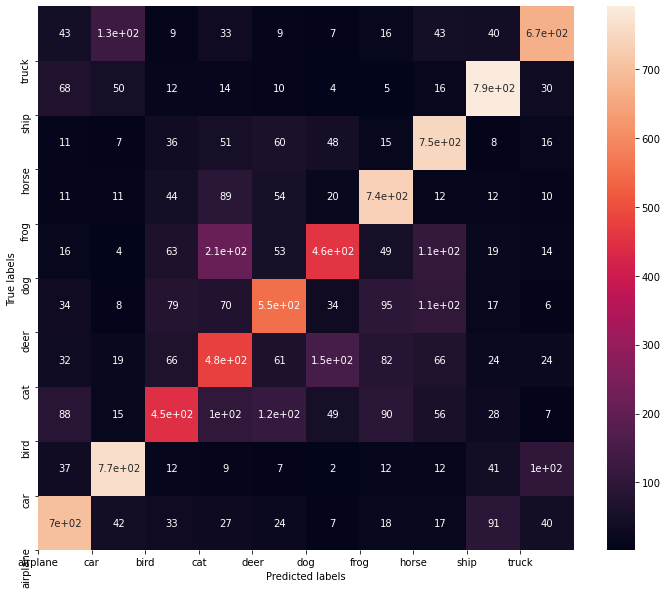

In [20]:
# Display a confusion matrix to better understand the results
CM = confusion_matrix(test_y, test_label_predicted)

plt.figure(figsize = (12,10))
sns.heatmap(CM, annot = True, annot_kws = {"size": 10})
plt.ylim([0, 10]);
plt.xticks(range(len(classes)), classes);
plt.yticks(range(len(classes)), classes);
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

In [21]:
# Present a classification report
print(classification_report(test_y, test_label_predicted,target_names=classes))

              precision    recall  f1-score   support

    airplane       0.67      0.70      0.69      1000
         car       0.73      0.77      0.75      1000
        bird       0.56      0.45      0.50      1000
         cat       0.44      0.48      0.46      1000
        deer       0.58      0.55      0.57      1000
         dog       0.59      0.46      0.51      1000
        frog       0.66      0.74      0.70      1000
       horse       0.63      0.75      0.68      1000
        ship       0.74      0.79      0.76      1000
       truck       0.73      0.67      0.70      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



### Display five random samples of each class titled with the true label and the predicted label

In [22]:
# Create list of five random indices from the length of testet (10,000)
rand_test_samples = np.random.randint(0,10000,(1,5))
rand_test_samples = rand_test_samples.tolist()
rand_test_samples = [item for sublist in rand_test_samples for item in sublist]

# Create list of five random samples from testset
rand_test_ims = [[None, None]] * 5
for i,r in enumerate(rand_test_samples):
    rand_test_ims[i] = testset[r]

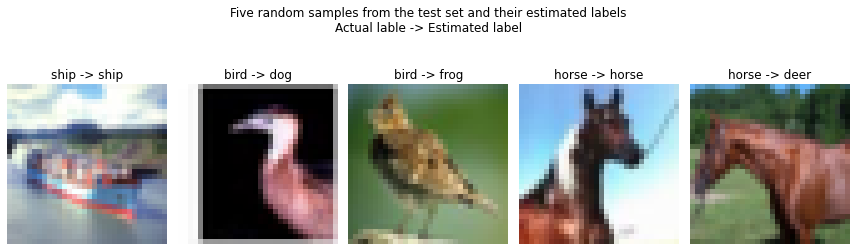

In [23]:
# Plot five random samples from the testset with actual label and predicted label
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Five random samples from the test set and their estimated labels\nActual lable -> Estimated label')

for index, im in enumerate(rand_test_ims):

    img = im[0]  
    img = img / 2 + 0.5 # unnormalize

    fig.add_subplot(1,5,index+1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title('%s -> %s' % (classes[test_y[rand_test_samples[index]]], classes[test_label_predicted[rand_test_samples[index]]]))
    plt.axis('off')

    plt.tight_layout()

plt.show()

**Citations:**
* Learning Multiple Layers of Features from Tiny Images.
    Alex Krizhevsky, 
    April 8, 2009. http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
    
* DeepLearningInBME_FirstTutorial, Soroush Arabshahi. https://www.kaggle.com/soroush361/deeplearninginbme-firsttutorial

* cifar10 with CNN for beginer, https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer    

* TRAINING A CLASSIFIER, http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

* PyTorch [Basics] — Sampling Samplers, https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a


* ImageNet Classification with Deep Convolutional
Neural Networks - AlexNet, https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf